In [2]:
!pip install kaggle

In [3]:
import os
import numpy as np
import pandas as pd
import random
import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
# Download the dataset
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection
!unzip brain-mri-images-for-brain-tumor-detection.zip -d data/

Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 33% 5.00M/15.1M [00:00<00:00, 40.8MB/s]
100% 15.1M/15.1M [00:00<00:00, 83.4MB/s]
Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: data/brain_tumor_dataset/no/1 no.jpeg  
  inflating: data/brain_tumor_dataset/no/10 no.jpg  
  inflating: data/brain_tumor_dataset/no/11 no.jpg  
  inflating: data/brain_tumor_dataset/no/12 no.jpg  
  inflating: data/brain_tumor_dataset/no/13 no.jpg  
  inflating: data/brain_tumor_dataset/no/14 no.jpg  
  inflating: data/brain_tumor_dataset/no/15 no.jpg  
  inflating: data/brain_tumor_dataset/no/17 no.jpg  
  inflating: data/brain_tumor_dataset/no/18 no.jpg  
  inflating: data/brain_tumor_dataset/no/19 no.jpg  
  inflating: data/brain_tumor_dataset/no/2 no.jpeg  
  inflating: data/brain_tumor_dataset/no/20 no.jpg  
  inflating: data/brain_tumor_dataset/no/21 no.jpg  
  inflating: data/brain_tumor_dataset/no/22 n

In [5]:
# Set data paths
data_dir = 'data/brain_tumor_dataset'
categories = ['yes', 'no']

In [6]:
# Initialize lists to hold the images and labels
tumor = []
healthy = []

# Load tumor images
for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

# Load healthy images
for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
    img = cv2.imread(f)
    img = cv2.resize(img, (128, 128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [7]:
# Convert lists to numpy arrays
tumor = np.array(tumor)
healthy = np.array(healthy)
All = np.concatenate((healthy, tumor))

In [8]:
healthy.shape

(85, 128, 128, 3)

In [9]:
tumor.shape

(86, 128, 128, 3)

In [10]:
np.random.choice(10, 5, replace=False)

array([9, 1, 7, 3, 8])

#Visualize the Dateset

In [11]:
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

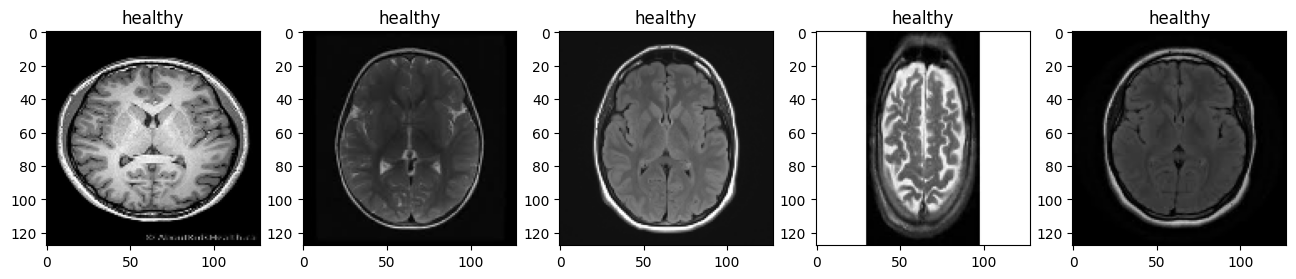

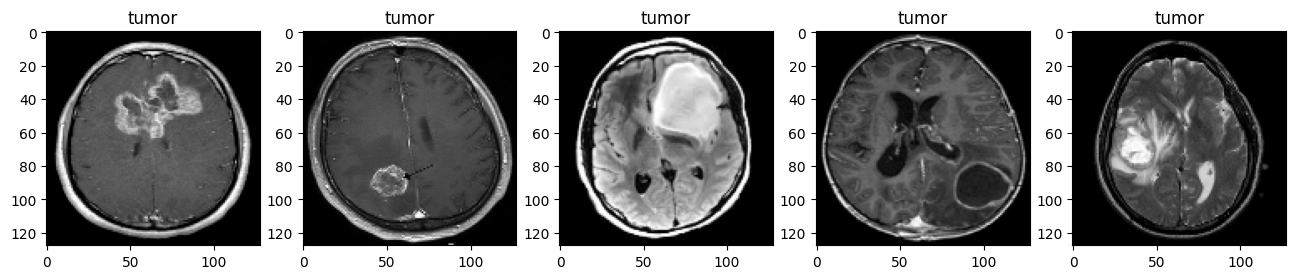

In [12]:
plot_random(healthy, tumor, num=5)

In [13]:
from sklearn.model_selection import train_test_split, KFold
from skimage.segmentation import slic
from skimage.filters import gaussian

In [14]:
# Create labels
tumor_labels = np.ones(len(tumor))
healthy_labels = np.zeros(len(healthy))

# Combine the data and labels
X = np.concatenate((tumor, healthy), axis=0)
y = np.concatenate((tumor_labels, healthy_labels), axis=0)

# Normalize the data
X = X / 255.0

In [15]:
# Apply superpixeling and smoothing techniques
def preprocess_image(image):
    segments = slic(image, n_segments=100, compactness=10, sigma=1)
    smooth_image = gaussian(image, sigma=1, multichannel=True)
    return smooth_image

X_preprocessed = np.array([preprocess_image(img) for img in X])

# Convert labels to categorical
y = to_categorical(y, num_classes=2)

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X_preprocessed):
    X_train, X_test = X_preprocessed[train_index], X_preprocessed[test_index]
    y_train, y_test = y[train_index], y[test_index]

<ipython-input-15-b1d1882416f9>:4: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  smooth_image = gaussian(image, sigma=1, multichannel=True)


In [16]:
# Count the number of images in the training and test sets
num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]

print(f'Number of training images: {num_train_images}')
print(f'Number of testing images: {num_test_images}')

Number of training images: 137
Number of testing images: 34


#Design a VGG16 Model

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [18]:
def create_vgg16_model(input_shape, num_classes, dropout_rate=0.5):
    # Load VGG16 model without the top layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of VGG16
    for layer in vgg16_base.layers:
        layer.trainable = False

    # Add custom layers on top of VGG16 base
    model = Sequential([
        vgg16_base,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    return model

# Assuming 'categories' is defined and contains the class labels
input_shape = (128, 128, 3)
num_classes = len(categories)
dropout_rate = 0.5  # Hyperparameter

# Create the model
model = create_vgg16_model(input_shape, num_classes, dropout_rate)

58889256/58889256 [==============================] - 0s 0us/step


In [19]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the Model

In [20]:
# Hyperparameters
batch_size = 4
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
35/35 [==============================] - 8s 84ms/step - loss: 1.4175 - accuracy: 0.5912 - val_loss: 1.0382 - val_accuracy: 0.5588
Epoch 2/50
35/35 [==============================] - 0s 14ms/step - loss: 0.6584 - accuracy: 0.7372 - val_loss: 0.5032 - val_accuracy: 0.7941
Epoch 3/50
35/35 [==============================] - 1s 17ms/step - loss: 0.4814 - accuracy: 0.8102 - val_loss: 0.4291 - val_accuracy: 0.8529
Epoch 4/50
35/35 [==============================] - 1s 17ms/step - loss: 0.4438 - accuracy: 0.7810 - val_loss: 0.3737 - val_accuracy: 0.7353
Epoch 5/50
35/35 [==============================] - 1s 16ms/step - loss: 0.5598 - accuracy: 0.7226 - val_loss: 0.4177 - val_accuracy: 0.8235
Epoch 6/50
35/35 [==============================] - 1s 16ms/step - loss: 0.3870 - accuracy: 0.8394 - val_loss: 0.3835 - val_accuracy: 0.8824
Epoch 7/50
35/35 [==============================] - 0s 14ms/step - loss: 0.2875 - accuracy: 0.8905 - val_loss: 0.4323 - val_accuracy: 0.8235
Epoch 8/50
35

#Evaluate the Model

In [21]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 3s 16ms/step - loss: 0.2993 - accuracy: 0.9118
Test Loss: 0.29928961396217346
Test Accuracy: 0.9117646813392639


#Visualize the Training History

In [22]:
import matplotlib.pyplot as plt

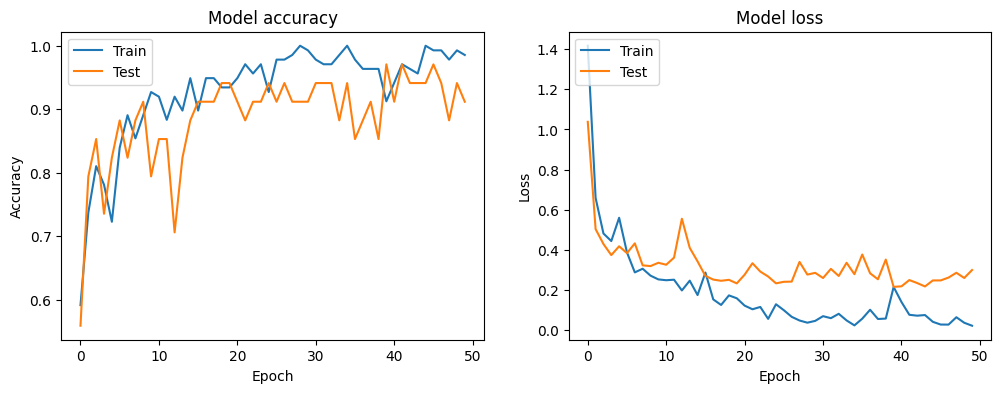

In [23]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [25]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 54ms/step


<Figure size 800x600 with 0 Axes>

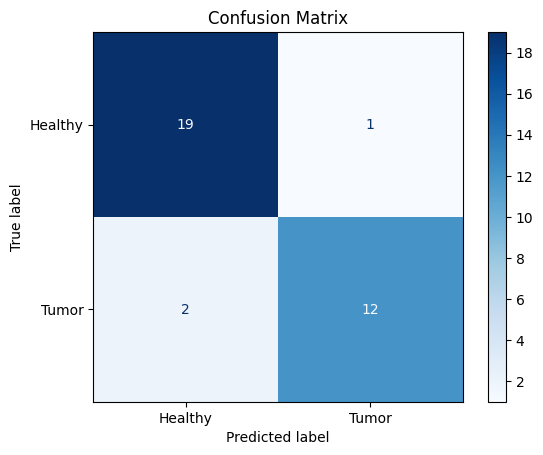

In [26]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Retrain the Model

In [27]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Hyperparameters
batch_size = 16
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 5s 239ms/step - loss: 0.0436 - accuracy: 0.9854 - val_loss: 0.2905 - val_accuracy: 0.9412
Epoch 2/50
9/9 [==============================] - 0s 32ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.2811 - val_accuracy: 0.9412
Epoch 3/50
9/9 [==============================] - 0s 32ms/step - loss: 0.0266 - accuracy: 0.9854 - val_loss: 0.2817 - val_accuracy: 0.9412
Epoch 4/50
9/9 [==============================] - 0s 32ms/step - loss: 0.0330 - accuracy: 0.9927 - val_loss: 0.2853 - val_accuracy: 0.9412
Epoch 5/50
9/9 [==============================] - 0s 31ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 0.2835 - val_accuracy: 0.9412
Epoch 6/50
9/9 [==============================] - 0s 32ms/step - loss: 0.0410 - accuracy: 0.9854 - val_loss: 0.2815 - val_accuracy: 0.9412
Epoch 7/50
9/9 [==============================] - 0s 32ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.2804 - val_accuracy: 0.9412
Epoch 8/50
9/9 [==========

#Evaluate the Model

In [29]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 15ms/step - loss: 0.3406 - accuracy: 0.9412
Test Loss: 0.34057143330574036
Test Accuracy: 0.9411764740943909


#Visualize the Training History

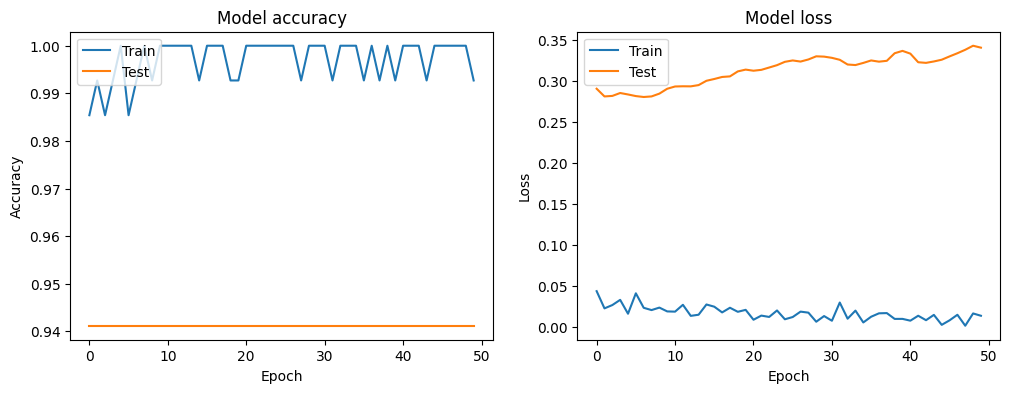

In [30]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [31]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 52ms/step


<Figure size 800x600 with 0 Axes>

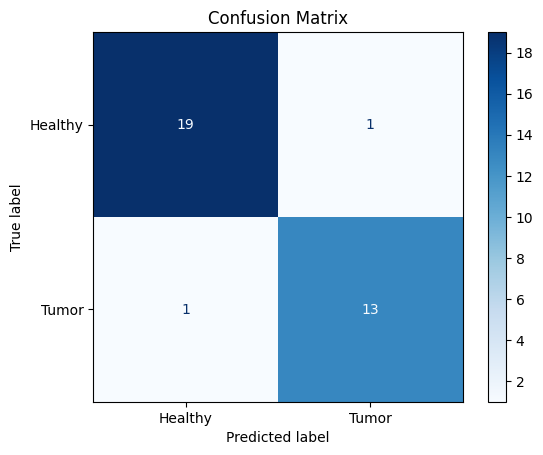

In [32]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()

#Retrain the Model

In [33]:
# Define the optimizer
optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08
)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Hyperparameters
batch_size = 32
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
5/5 [==============================] - 2s 196ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.3464 - val_accuracy: 0.9412
Epoch 2/50
5/5 [==============================] - 0s 56ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.3513 - val_accuracy: 0.9412
Epoch 3/50
5/5 [==============================] - 0s 53ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.9412
Epoch 4/50
5/5 [==============================] - 0s 53ms/step - loss: 0.0111 - accuracy: 0.9927 - val_loss: 0.3455 - val_accuracy: 0.9412
Epoch 5/50
5/5 [==============================] - 0s 57ms/step - loss: 0.0074 - accuracy: 1.0000 - val_loss: 0.3459 - val_accuracy: 0.9412
Epoch 6/50
5/5 [==============================] - 0s 60ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.3478 - val_accuracy: 0.9412
Epoch 7/50
5/5 [==============================] - 0s 54ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.3469 - val_accuracy: 0.9412
Epoch 8/50
5/5 [==========

#Evaluate the Model

In [35]:
#Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 0s 16ms/step - loss: 0.3731 - accuracy: 0.9412
Test Loss: 0.3730757534503937
Test Accuracy: 0.9411764740943909


#Visualize the Training History

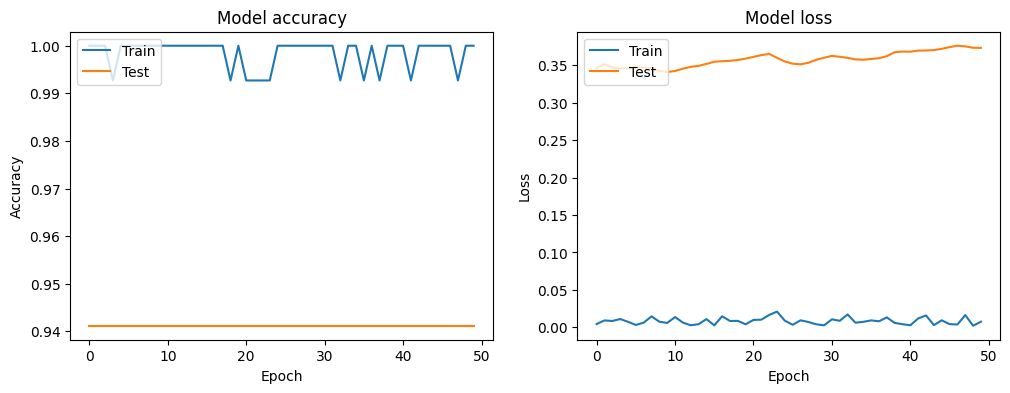

In [36]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

#Make Prediction

In [37]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

2/2 [==============================] - 0s 51ms/step


<Figure size 800x600 with 0 Axes>

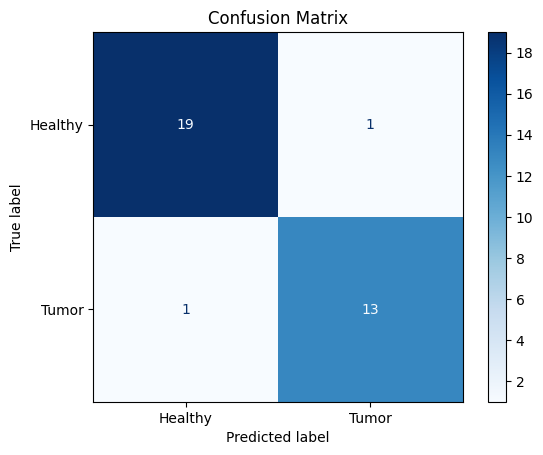

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.show()